In [37]:
%run paper/setup.py

In [38]:
t, y = np.loadtxt('paper/data/dsct_eigenfrequencies.txt', usecols=(0,1)).T
y *= 1e3

In [39]:
from maelstrom.utils import amplitude_spectrum

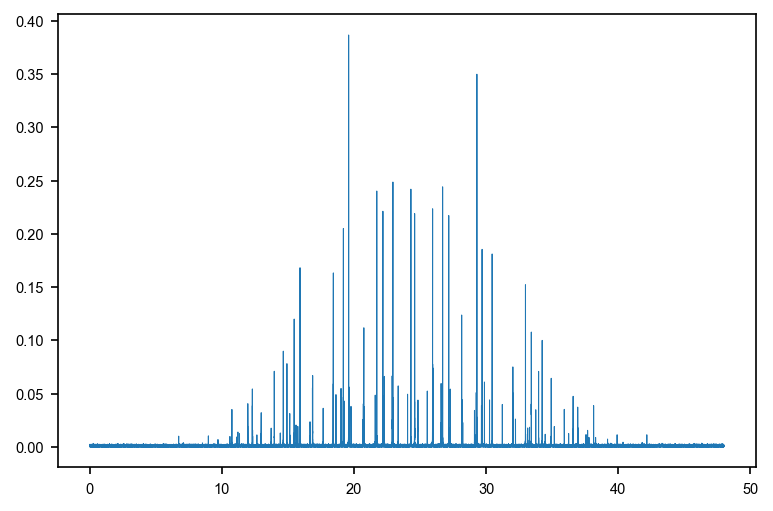

In [40]:
plt.plot(*amplitude_spectrum(t,y, fmax=48), linewidth=0.5)

In [41]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
from tqdm import tqdm

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, phi):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.phi = period, eccen, asini, varpi, phi
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * tt.constant(self.time) / self.period - self.phi
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = ((1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in tqdm(zip(self.freq, self.amplitude), total=len(self.freq)):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.sin(omega * (self.time - self.tau - np.random.rand()*2*np.pi))# + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        s_rms = self.amplitude.max() / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

In [42]:
from maelstrom.utils import mass_function
import astropy.units as u

In [36]:
masses = [1, 5, 10]
periods = [10, 100, 1000]

from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

def gen_model(time, flux, freq, period_guess, a_guess, with_gp=False, with_eccen=False):
    new_model = pm.Model()
    with new_model:
        # Period
#         logP = pm.Normal("logP", mu=np.log(period_guess), sd=50, shape=1, testval=np.log(period_guess))
        logP = pm.Bound(pm.Normal,
                                 lower=np.log(1),
                                 upper=np.log(1500))("logP", mu=np.log(period_guess), sd=5, shape=1, testval=np.log(period_guess))
        period = pm.Deterministic("period", pm.math.exp(logP))
        asini = pm.Normal('asini', mu=a_guess, sd=3, testval=a_guess)
        phi = xo.distributions.Angle('phi', testval=0)
        mean = pm.Normal("mean", mu=np.mean(flux), sd=10.0, testval=np.mean(flux))
        logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(flux)))))
        sigma = pm.Deterministic('sigma', tt.exp(2*logs_lc))
        #     logs_lc = pm.HalfNormal("logs_lc",  sigma=0.25, testval=0.05)
        M = 2.0 * np.pi * (time) / period - phi

        if with_eccen:
            varpi = xo.distributions.Angle('varpi', testval=0)
            eccen = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.001)
            f = get_true_anomaly(M, eccen + tt.zeros_like(M))
            psi = (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
        else:
            psi = tt.sin(M)

        lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
        nu = pm.Deterministic("nu", tt.exp(lognu))
        tau = ((asini) / 86400) * psi[:, None]
        arg = 2. * np.pi * nu * (time[:, None] - tau)
        D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
        w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, flux))
        pm.Deterministic('w', w)
        lc_model = tt.dot(D, w)
        full_lc = lc_model - mean

        if with_gp:
            logw0 = pm.Bound(pm.Normal,
                             lower=np.log(2*np.pi/100.0),
                             upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                        testval=np.log(2*np.pi/10))
            logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
            logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
            kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
            gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)

            pm.Potential("obs", gp.log_likelihood(flux - full_lc))
        else:
            pm.Normal('obs', mu=full_lc, 
                      sd=sigma, 
                      observed=flux)
            
        plt.plot(lc.time, xo.eval_in_model(psi * asini))
        plt.plot(lc.time, lc.tau*86400)
        plt.show()
    return new_model

100%|██████████| 3/3 [00:00<00:00, 645.97it/s]


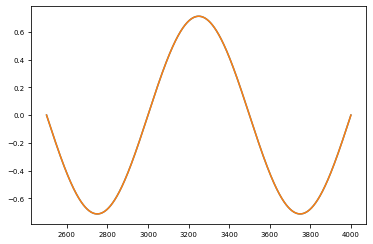

optimizing logp for variables: [logs_lc, mean]
155it [00:02, 52.22it/s, logp=-1.717168e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -70014.29413690792 -> -17171.6843444573
optimizing logp for variables: [phi]
15it [00:00, 28.44it/s, logp=-1.715077e+04]
message: Optimization terminated successfully.
logp: -17171.6843444573 -> -17150.772132277627
optimizing logp for variables: [lognu]
78it [00:02, 37.91it/s, logp=-1.714981e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17150.772132277627 -> -17149.81045107338
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
99it [00:02, 37.56it/s, logp=-1.714981e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17149.81045107338 -> -17149.81045103486
optimizing logp for variables: [asini]
6it [00:00, 21.23it/s, logp=-1.714922e+04]
message: Optimization terminated successfully.
logp: -17149.81045103486 -> -17149.218574774968
opt

{'logP': array([7.005084]), 'asini': array(1.25661533), 'phi_angle__': array([-2.95062089, -3.36063179]), 'mean': array(0.002328), 'logs_lc': array(-0.59247177), 'lognu': array([3.40119736, 3.68887947, 3.912023  ]), 'period': array([1102.22263405]), 'phi': array(-2.42106838), 'sigma': array(0.30576344), 'nu': array([29.99999927, 40.00000068, 49.99999992]), 'w': array([-0.04560949,  0.72262293,  0.38663501, -0.79819827,  0.34237649,
        0.91963954])}
1000 0.712


Sampling 2 chains: 100%|██████████| 2000/2000 [09:13<00:00,  2.29draws/s]
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 3/3 [00:00<00:00, 479.79it/s]


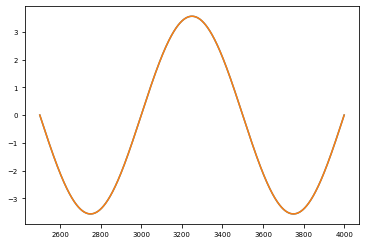

optimizing logp for variables: [logs_lc, mean]
20it [00:00, 41.72it/s, logp=-1.717167e+04]
message: Optimization terminated successfully.
logp: -66996.01376907315 -> -17171.66902772825
optimizing logp for variables: [phi]
14it [00:00, 27.88it/s, logp=-1.715116e+04]
message: Optimization terminated successfully.
logp: -17171.66902772825 -> -17151.155372086225
optimizing logp for variables: [lognu]
96it [00:02, 39.02it/s, logp=-1.715080e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17151.155372086225 -> -17150.798790296736
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
90it [00:02, 34.94it/s, logp=-4.642961e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -17150.798790296736 -> -17150.798790296736
optimizing logp for variables: [asini]
5it [00:00, 19.65it/s, logp=-1.715076e+04]
message: Optimization terminated successfully.
logp: -17150.798790296736 -> -17150.755051131266
optimizing logp for va

{'logP': array([6.90697874]), 'asini': array(3.41180422), 'phi_angle__': array([0.20817954, 4.46728847]), 'mean': array(0.00232801), 'logs_lc': array(-0.59245688), 'lognu': array([3.40119737, 3.68887947, 3.91202301]), 'period': array([999.2237662]), 'phi': array(0.04656718), 'sigma': array(0.30577255), 'nu': array([29.99999974, 40.00000056, 50.00000002]), 'w': array([ 0.25184196,  0.78150974, -0.45616933, -0.75938806,  0.16609642,
       -0.8924376 ])}
1000 3.56


100%|██████████| 3/3 [00:00<00:00, 508.50it/s]


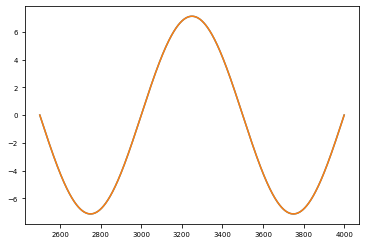

optimizing logp for variables: [logs_lc, mean]
20it [00:00, 40.91it/s, logp=-1.717167e+04]
message: Optimization terminated successfully.
logp: -67031.48620661865 -> -17171.66662744904
optimizing logp for variables: [phi]
84it [00:02, 38.45it/s, logp=-1.715115e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17171.66662744904 -> -17151.151731246893
optimizing logp for variables: [lognu]
78it [00:02, 38.94it/s, logp=-1.715080e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17151.151731246893 -> -17150.79659195646
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
98it [00:02, 35.72it/s, logp=-1.715080e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17150.79659195646 -> -17150.796591918504
optimizing logp for variables: [asini]
5it [00:00, 20.11it/s, logp=-1.715075e+04]
message: Optimization terminated successfully.
logp: -17150.796591918504 -> -17150.752571724697


{'logP': array([6.89258161]), 'asini': array(7.02295935), 'phi_angle__': array([1.4584349 , 4.22764327]), 'mean': array(0.00232812), 'logs_lc': array(-0.59246133), 'lognu': array([3.40119737, 3.68887947, 3.91202301]), 'period': array([984.94087373]), 'phi': array(0.33219198), 'sigma': array(0.30576982), 'nu': array([29.99999973, 40.00000055, 50.00000002]), 'w': array([ 0.25170646,  0.78153429, -0.45619484, -0.75943162,  0.16596657,
       -0.8924102 ])}
1000 7.12


Sampling 2 chains: 100%|██████████| 2000/2000 [06:55<00:00,  3.22draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [123]:
period_t = 100#periods[3]
asinis = [0.712,3.56,7.12]
freqs = np.array([30, 40, 50])#dsct_freq
amps = np.array([0.8, 0.8, 1])#dsct_amp
time = t

for asini in asinis:
    lc = SyntheticBinary(time, freqs, amps,
                         period_t, 0, asini, 0, 0)
    np.random.seed(23)
    lc.add_noise(snr=500)
    model = gen_model(lc.time, lc.flux, freqs, period_t, asini)
    
    with model:
        map_params = xo.optimize(start=None, vars=[model.mean,model.logs_lc])
        map_params = xo.optimize(start=map_params, vars=[model.phi])
        map_params = xo.optimize(start=map_params, vars=[model.lognu])
        map_params = xo.optimize(start=map_params)

        map_params = xo.optimize(start=map_params, vars=[model.asini])
        map_params = xo.optimize(start=map_params)
        map_params = xo.optimize(start=map_params, vars=[model.logP])
    print(map_params)
    print(period_t, asini)
    sampler = xo.PyMC3Sampler(start=100, window=100, finish=500, chains=2)
    with model:
        burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)
        trace = sampler.sample(draws=1000)
    
    pm.save_trace(trace, 'traces/planet_test/1000d_' + str(asini))

100%|██████████| 3/3 [00:00<00:00, 253.66it/s]


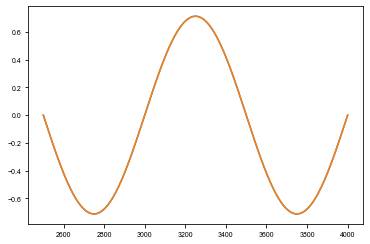

In [34]:
period_t = 1000#periods[3]
asinis = [0.712,3.56,7.12]
freqs = np.array([30, 40, 50])#dsct_freq
amps = np.array([0.8, 0.8, 1])#dsct_amp
time = t

lc = SyntheticBinary(time, freqs, amps,
                         period_t, 0, 0.712, 0, 0)
np.random.seed(23)
lc.add_noise(snr=500)
model = gen_model(lc.time, lc.flux, freqs, period_t, 0.712)
    
with model:
    trace = pm.load_trace('traces/planet_test/1000d_7.12')

In [35]:
df = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
masses = (mass_function(df['period__0'].values*u.day, df['asini'].values*u.s).to(u.M_jup))**(1/3) * ((1.5*u.M_sun).to(u.M_jup))**(2/3)
upper, med, lower = np.percentile(masses, [84.13, 50, 15.86])
print(med, upper-med, med-lower)

9.876952933618032 0.7746576694752783 0.7273053369797324


In [19]:
from astropy import constants as const
import astropy.units as u

def rev_mass_function(period, mass):
    asini =( (4*np.pi**2 * (1*const.c**3)) / (1*const.G) * 1 / (period.to(u.s)**2) * mass.to(u.M_sun))**(-1/3)
    return asini

In [6]:
from astropy import constants as const
import astropy.units as u

def mass_function(period, asini):
    consts = (4*np.pi**2 * (1*const.c**3)) / (1*const.G)
    si = (asini**3) * consts / (period.to(u.s)**2)
    return si.to(u.M_sun)

In [44]:



stellar_mass = 1.8
(mass_function(1000*u.day, 0.712*u.s).to(u.M_jup))**(1/3) * ((1.5*u.M_sun).to(u.M_jup))**(2/3)

<Quantity 1.00080531 jupiterMass>

In [102]:
# from maelstrom.utils import amplitude_spectrum
from tqdm import tqdm
# Fixed parameters

period_t = 1000.
asini_t = 7.12

eccen_t = 0.
varpi_t = 0.
phi_t = 0.

#n_freq = 1
freqs = np.array([30, 40, 50])#dsct_freq
amps = np.array([0.8, 0.8, 1])#dsct_amp

# TESS 2 min cadence for 1 sector
# time = np.arange(0, 27, 1.0 / (24 * 30))
time = t

lc = SyntheticBinary(time, freqs, amps,
                     period_t, eccen_t, asini_t, varpi_t, phi_t)
np.random.seed(23)
lc.add_noise(snr=500)

100%|██████████| 3/3 [00:00<00:00, 788.16it/s]


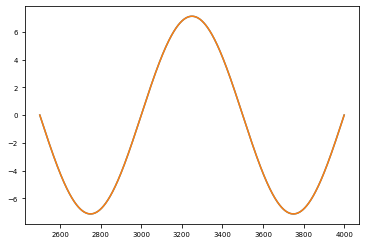

In [76]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [77]:
segment = 3
t0s = np.arange(lc.time.min(), lc.time.max(), 1)
phases = np.empty((len(t0s)-1, len(freqs)))
phases[:] = np.nan
for i, t0 in tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= lc.time) & (lc.time < t0s[i+1])
#     if m.sum() < 100:
#         continue
    phases[i] = get_phase(freqs, lc.time[m], lc.flux[m])
m = np.isfinite(phases[:, 0])
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

100%|██████████| 1499/1499 [00:00<00:00, 2671.48it/s]


(1043.798972297358, 2.7525948856971367)

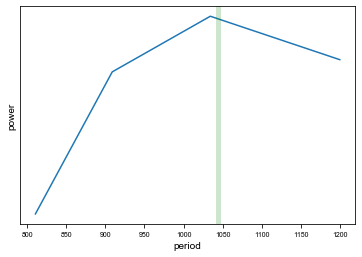

In [78]:
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], full[m], min_period=800,#2*segment, 
                                           max_period=1200)
f, p = res["periodogram"]
plt.plot(1 / f, p)
plt.axvline(res["peaks"][0]["period"], color="green", linewidth=5, alpha=0.2)
plt.xlabel("period")
plt.ylabel("power")
plt.yticks([]);

period_guess = res["peaks"][0]["period"]
arg = 2*np.pi*t0s[:-1][m]/period_guess
D = np.concatenate((np.sin(arg)[:, None],
                    np.cos(arg)[:, None],
                    np.ones((len(phases[m]), 1))), axis=-1)
w = np.linalg.solve(np.dot(D.T, D), np.dot(D.T, phases[m, 0]))
a_guess = np.sqrt(np.sum(w[:2]**2)) * 86400
period_guess, a_guess

In [73]:
from tqdm import tqdm

time, mag = ms.time, ms.flux
freq = freqs
with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, mag))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=mag)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

#periods = np.exp(np.linspace(np.log(10), np.log(25), 50))
periods = np.linspace(80, 120, 50)
results = []
for f in freq[:2]:
    results.append([run_fit(p, f) for p in tqdm(periods)])

NameError: name 'ms' is not defined

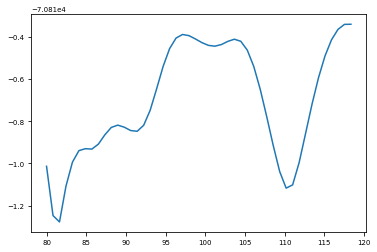

In [67]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

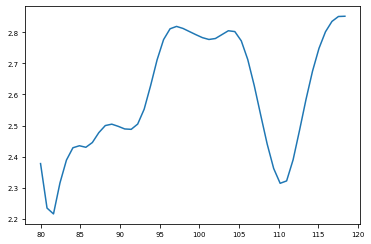

In [68]:
ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
sm = np.median(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

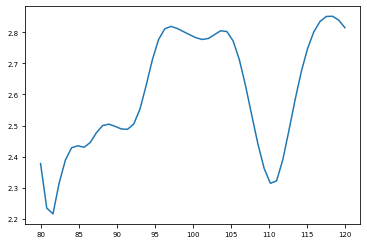

In [69]:
ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
for i in ys:
    plt.plot(periods, i)

In [70]:
period_guess = periods[period_ind]
a_guess = np.max(sm)
period_guess, a_guess


(118.36734693877551, 2.851333670178876)

In [79]:
period_guess, a_guess, freqs

(1043.798972297358, 2.7525948856971367, array([30, 40, 50]))

In [80]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

def gen_model(time, flux, freq, period_guess, a_guess, with_gp=False, with_eccen=False):
    new_model = pm.Model()
    with new_model:
        # Period
        logP = pm.Normal("logP", mu=np.log(period_guess), sd=50, shape=1, testval=np.log(period_guess))
        period = pm.Deterministic("period", pm.math.exp(logP))
        asini = pm.Normal('asini', mu=a_guess, sd=3, testval=a_guess)
        phi = xo.distributions.Angle('phi', testval=0)
        mean = pm.Normal("mean", mu=np.mean(flux), sd=10.0, testval=np.mean(flux))
        logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(flux)))))
        sigma = pm.Deterministic('sigma', tt.exp(2*logs_lc))
        #     logs_lc = pm.HalfNormal("logs_lc",  sigma=0.25, testval=0.05)
        M = 2.0 * np.pi * (time) / period - phi

        if with_eccen:
            varpi = xo.distributions.Angle('varpi', testval=0)
            eccen = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.001)
            f = get_true_anomaly(M, eccen + tt.zeros_like(M))
            psi = -(1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
        else:
            psi = -tt.sin(M)

        lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
        nu = pm.Deterministic("nu", tt.exp(lognu))
        tau = ((asini) / 86400) * psi[:, None]
        arg = 2. * np.pi * nu * (time[:, None] - tau)
        D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
        w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, flux))
        pm.Deterministic('w', w)
        lc_model = tt.dot(D, w)
        full_lc = lc_model - mean

        if with_gp:
            logw0 = pm.Bound(pm.Normal,
                             lower=np.log(2*np.pi/100.0),
                             upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                        testval=np.log(2*np.pi/10))
            logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
            logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
            kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
            gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)

            pm.Potential("obs", gp.log_likelihood(flux - full_lc))
        else:
            pm.Normal('obs', mu=full_lc, 
                      sd=sigma, 
                      observed=flux)
            
    return new_model

model = gen_model(lc.time, lc.flux, freqs, period_guess, a_guess)

In [81]:
with model:
    map_params = xo.optimize(start=None, vars=[model.mean,model.logs_lc])
    map_params = xo.optimize(start=map_params, vars=[model.phi])
    map_params = xo.optimize(start=map_params, vars=[model.lognu])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[model.asini])
    map_params = xo.optimize(start=map_params)
    map_params = xo.optimize(start=map_params, vars=[model.logP])

optimizing logp for variables: [logs_lc, mean]
168it [00:04, 38.17it/s, logp=-1.721197e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -70037.0285817272 -> -17211.974008590285
optimizing logp for variables: [phi]
15it [00:00, 23.04it/s, logp=-1.715006e+04]
message: Optimization terminated successfully.
logp: -17211.974008590285 -> -17150.063525636673
optimizing logp for variables: [lognu]
93it [00:03, 30.10it/s, logp=-1.714911e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17150.063525636673 -> -17149.114309981756
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
165it [00:05, 30.66it/s, logp=-1.714903e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -17149.114309981756 -> -17149.02786515029
optimizing logp for variables: [asini]
3it [00:00,  4.47it/s, logp=-1.714903e+04]
message: Optimization terminated successfully.
logp: -17149.02786515029 -> -17149.0278651502

In [83]:
map_params

{'logP': array([6.94903515]),
 'asini': array(2.58161807),
 'phi_angle__': array([ 3.91985243, -2.15284933]),
 'mean': array(0.00232803),
 'logs_lc': array(-0.59247183),
 'lognu': array([3.40119736, 3.68887947, 3.91202301]),
 'period': array([1042.1437321]),
 'phi': array(2.07303814),
 'sigma': array(0.30576341),
 'nu': array([29.99999932, 40.00000075, 50.        ]),
 'w': array([-0.0448259 ,  0.7221637 ,  0.38509981, -0.79824311,  0.34334155,
         0.92028878])}

In [84]:
sampler = xo.PyMC3Sampler(start=100, window=100, finish=500, chains=2)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains:   6%|▌         | 23/404 [02:25<39:40,  6.25s/draws] 


ValueError: Not enough samples to build a trace.

[phi_angle__, logs_lc, asini, mean, lognu]


optimizing logp for variables: [mean]
5it [00:00, 20.84it/s, logp=-6.827090e+04]
message: Optimization terminated successfully.
logp: -68271.53359146534 -> -68270.89756751999
optimizing logp for variables: [logs_lc]
12it [00:00, 33.70it/s, logp=3.361022e+04]
message: Optimization terminated successfully.
logp: -68270.89756751999 -> 33610.216083430205
optimizing logp for variables: [phi]
14it [00:00, 22.79it/s, logp=3.366268e+04]
message: Optimization terminated successfully.
logp: 33610.216083430205 -> 33662.678680944904
optimizing logp for variables: [lognu]
76it [00:02, 26.15it/s, logp=3.366373e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 33662.678680944904 -> 33663.730333313695
optimizing logp for variables: [lognu, mean, asini, logs_lc, phi]
107it [00:04, 23.47it/s, logp=3.366373e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 33663.730333313695 -> 33663.730333361134
optimizing logp for variables: [asini]
6it [0

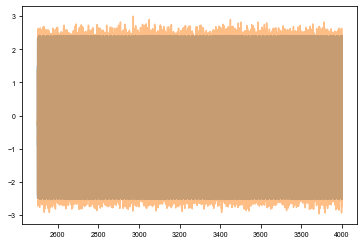

In [28]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=map_params, vars=[phase, logamp])
#     map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [29]:
map_params

{'logP_interval__': array(-5.59753796),
 'phi_angle__': array([-2.14068454, -3.92650622]),
 'logs_lc': array(-1.87810769),
 'asini': array(0.60013125),
 'mean': array(-0.00116393),
 'lognu': array([3.40119737, 3.68887947, 3.912023  ]),
 'logP': array(2.32553743),
 'period': array(10.23217771),
 'phi': array(-2.64245129),
 'nu': array([29.99999971, 40.00000045, 49.99999997]),
 'mass_function': array(4.40763395e+24)}

In [95]:
sampler = xo.PyMC3Sampler(start=100, window=100, finish=500, chains=2)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
Sampling 2 chains:  44%|████▍     | 534/1204 [44:09<2:28:16, 13.28s/draws]


ValueError: Not enough samples to build a trace.

In [113]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.184980e+00,2.587202e-03,8.446848e-05,-1.189964e+00,-1.179802e+00,744.746085,0.999527
mean,-1.055745e-04,1.088681e-03,3.677544e-05,-2.268896e-03,1.860111e-03,685.952393,1.001982
lognu__0,3.912023e+00,1.475948e-08,7.538497e-10,3.912023e+00,3.912023e+00,384.507109,1.001926
logP,5.709772e+00,1.767603e+00,8.698861e-02,2.738882e+00,8.487763e+00,235.107832,1.004883
period,9.732761e+02,1.290794e+03,5.239732e+01,1.003408e+01,4.010982e+03,521.815191,1.007127
phi,7.328886e-03,1.768326e+00,8.445649e-02,-3.012153e+00,2.853028e+00,323.255937,1.000257
logasini,-2.814298e+00,2.064657e+00,1.046570e-01,-6.669851e+00,3.992745e-01,308.950331,1.000035
asini,3.212217e-01,8.553289e-01,5.557884e-02,1.038052e-03,1.296913e+00,221.594968,1.000397
nu__0,5.000000e+01,7.379742e-07,3.769248e-08,5.000000e+01,5.000000e+01,384.507125,1.001926
mass_function,5.374470e+23,3.027200e+24,2.819122e+23,3.970389e+11,1.835203e+23,36.838411,1.027540


'traces/planet_test/1000d_0x7'

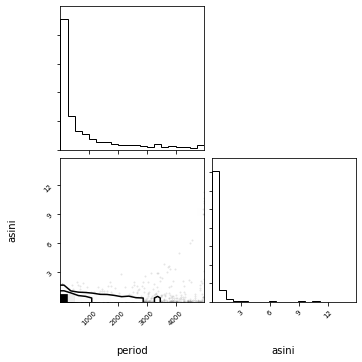

In [116]:
corner.corner(pm.trace_to_dataframe(trace, varnames=['period', 'asini']));

In [117]:

varnames=['period', 'asini', 'phi']
rounding = 4
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  352.7597  +  2014.3835  -  317.6816
asini :  0.068  +  0.4588  -  0.0627
phi :  0.117  +  1.9016  -  2.2087


In [118]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.184980e+00,2.587202e-03,8.446848e-05,-1.189964e+00,-1.179802e+00,744.746085,0.999527
mean,-1.055745e-04,1.088681e-03,3.677544e-05,-2.268896e-03,1.860111e-03,685.952393,1.001982
lognu__0,3.912023e+00,1.475948e-08,7.538497e-10,3.912023e+00,3.912023e+00,384.507109,1.001926
logP,5.709772e+00,1.767603e+00,8.698861e-02,2.738882e+00,8.487763e+00,235.107832,1.004883
period,9.732761e+02,1.290794e+03,5.239732e+01,1.003408e+01,4.010982e+03,521.815191,1.007127
phi,7.328886e-03,1.768326e+00,8.445649e-02,-3.012153e+00,2.853028e+00,323.255937,1.000257
logasini,-2.814298e+00,2.064657e+00,1.046570e-01,-6.669851e+00,3.992745e-01,308.950331,1.000035
asini,3.212217e-01,8.553289e-01,5.557884e-02,1.038052e-03,1.296913e+00,221.594968,1.000397
nu__0,5.000000e+01,7.379742e-07,3.769248e-08,5.000000e+01,5.000000e+01,384.507125,1.001926
mass_function,5.374470e+23,3.027200e+24,2.819122e+23,3.970389e+11,1.835203e+23,36.838411,1.027540
